In [1]:

'''
Author: Damiano Pasquini
email: damiano23@ru.is
'''

import os, sklearn, graphviz, logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
def pre_process_data(data_frame):
    """
    Preprocess the columns of the given dataframe
    :param data_frame: data frame to preprocess
    :return: the preprocessed dataframe
    """
    data_frame.rename(columns=lambda x: x.strip(), inplace=True)  # Remove leading/trailing spaces from column names
    data_frame["Label"] = data_frame["Label"].apply(lambda x: x.strip()) # Remove leading/trailing spaces from column values
    data_frame.replace([np.inf], np.finfo(np.float32).max, inplace=True) # Replace inf values with max of float 32
    data_frame.replace([-np.inf], -np.finfo(np.float32).min, inplace=True) # Replace inf values with min value of float 32
    data_frame.fillna(0, inplace=True) # Replace all NaN values with 0
    data_frame["Label"] = data_frame["Label"].apply(lambda x : preprocess_label_column(x)) # Preprocess the column "Label"
    encoder = OneHotEncoder() # One hot encode the column "Label"
    encoded_data = encoder.fit_transform(data_frame[['Label']])    
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Label']))
    return encoded_df

In [3]:
def preprocess_label_column(label):
    """
    Transform the content of the column "Label". If the value is "BENIGN" then it is changed to "Benign", if it contains "DoS" then 
    it is changed to "DoS", if it contains "PortScan" then it is changed to "Scan", otherwise it is changed to "Exploit"
    :param label: row of the column "Label" of the dataset
    :return: the value to be assigned to the row of the column "Label" of the dataset
    """
    if "BENIGN" in label:
        return "Benign"
    elif "DoS" in label:
        return "DoS"
    elif "PortScan" in label:
        return "Scan"
    else:
        return "Exploit"

In [4]:

def merge_csv_files(path_to_csv_files, index=True, write_to_file=False):
    """
    Merge all the csv files in the given directory into a single dataframe
    :param path_to_csv_files: directory where the csv files are located
    :param index: write row names if true
    :param write_to_file: write the merged dataframe to a csv file if true
    :return: the merged dataframe
    """
    csv_files = [f for f in os.listdir(path_to_csv_files) if f.endswith('.csv')]
    dfs = [pd.read_csv(os.path.join(path_to_csv_files, f)) for f in csv_files]
    df = pd.concat(dfs, ignore_index=True)
    if write_to_file:
        df.to_csv("./combined.csv", index=index)
    return df

In [5]:
def train_test_by_days(path_to_files):
    """
    Split the dataset in training and testing dataset by days
    :param path_to_files: directory where the csv files are located
    :return: d_train and d_test, relatively training dataset and testing dataset
    """
    d_train = pd.DataFrame()
    d_test = pd.DataFrame()
    for file in os.listdir(path_to_files):
        if file.endswith(".csv"):
            day = file.split("-")[0]
            with open(os.path.join(path_to_files, file), "r") as f:
                df = pd.read_csv(f)
                if day in ["Monday", "Tuesday", "Wednesday"]:
                    d_train = pd.concat([d_train, df])
                else:
                    d_test = pd.concat([d_test, df])
    pre_process_data(d_train)
    pre_process_data(d_test)
    return d_train, d_test

In [6]:
def get_dataset(path_to_files, splitmode=None):
    """
    Function to obtain the train dataset and the test dataset given the path where the csv files are,
    and the percentage of training dataset
    :param path_to_files: directory where the csv files are located 
    :param splitmode: number between 0 and 1, if specified indicates the percentage of the train set (d_train)  
    :return: d_train and d_test, relatively training dataset and testing dataset
    """
    if splitmode is not None and (splitmode < 0 or splitmode > 1):
        raise ValueError("splitmode should be between 0 and 1")
    
    d_train = pd.DataFrame()
    d_test = pd.DataFrame()
    if splitmode:
        df = merge_csv_files(path_to_files)
        pre_process_data(df)
        df = sklearn.utils.shuffle(df)
        split_index = int(len(df) * splitmode)
        d_train = pd.concat([d_train, df[:split_index]])
        d_test = pd.concat([d_test, df[split_index:]])
    else:
        d_train, d_test = train_test_by_days(path_to_files)
    return d_train, d_test

In [7]:
def split_x_y(data):
    """
    Split the dataset in data and labels (relatively X and y)
    :param data: dataset
    :return: tuple X and y, relatively data and labels for the given dataset
    """
    X = data.drop(columns=["Label"])
    y = data["Label"]
    return X, y

In [8]:
'''preprocess data splitting by days'''
def preprocessing(dataset_path, splitmode=None):
    train_set, test_set = get_dataset(dataset_path, splitmode=splitmode)
    X_train, y_train = split_x_y(train_set)
    X_test, y_test = split_x_y(test_set)
    return X_train, y_train, X_test, y_test

In [9]:
'''train the decision tree classifier'''
def train_decision_tree_classifier(X_train, y_train, X_test, y_test, splitmode=None):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_metrics(y_test, y_pred, classifier_name="decision_tree_classifier", splitmode=splitmode)
    return clf

In [10]:
'''train the random forest classifier'''
def train_random_forest_classifier(X_train, y_train, X_test, y_test, splitmode=None):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_metrics(y_test, y_pred, classifier_name="random_forest_classifier", splitmode=splitmode)

In [11]:
'''Print accuracy, classification report and confusion matrix'''
def print_metrics(y_test, y_pred, classifier_name=None, splitmode=None):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    cr = classification_report(y_test, y_pred, zero_division=0.0)
    print(cr)
    cm = confusion_matrix(y_test, y_pred)
    cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                        display_labels = ["DoS", "Scan", "Benign", "Exploit"])
    cm.plot()
    plt.show()
    # save results
    if classifier_name:
        new_path = "./results/"+str(classifier_name)+"/"+str(splitmode)
        if not os.path.exists(new_path):
            os.makedirs(new_path)
        with open(new_path+"/classification_report.txt", "w") as f:
            f.write(str("Accuracy: "+str(accuracy)+"\n"))
            f.write(cr)
        cm.figure_.savefig(new_path+"/confusion_matrix.png")

In [12]:
'''plot the decision tree with graphviz and save it in a pdf file'''
def plot_decision_tree(clf, X_train, splitmode=None):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns.tolist(),  
                                class_names=["DoS", "Scan", "Benign", "Exploit"],  
                                filled=True, rounded=True,  
                                special_characters=True)
    graph = graphviz.Source(dot_data)
    name = "dtc_"+str(splitmode)
    dir = "./results/plotted_trees/"+str(splitmode)
    if not os.path.exists(dir):
        os.makedirs(dir)
    graph.render(name, directory=dir, format="pdf")

Accuracy:  0.9986929235943188
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    909496
         DoS       1.00      1.00      1.00    152245
     Exploit       0.97      0.98      0.97      7120
        Scan       0.99      0.99      0.99     63437

    accuracy                           1.00   1132298
   macro avg       0.99      0.99      0.99   1132298
weighted avg       1.00      1.00      1.00   1132298


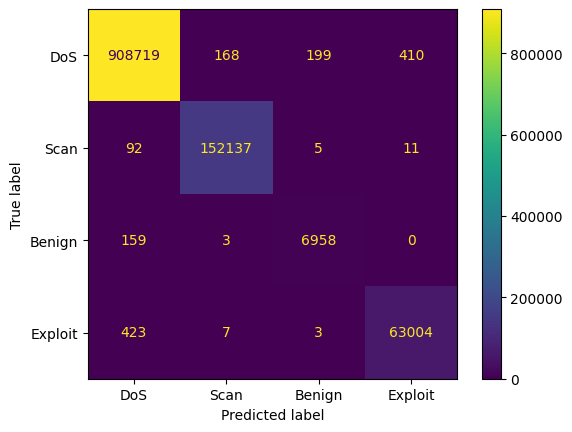

Accuracy:  0.8183895723073137
              precision    recall  f1-score   support

      Benign       0.81      1.00      0.89    871074
         DoS       0.97      0.63      0.76    128027
     Exploit       0.58      0.16      0.26      4182
        Scan       0.00      0.00      0.00    158930

    accuracy                           0.82   1162213
   macro avg       0.59      0.45      0.48   1162213
weighted avg       0.71      0.82      0.75   1162213


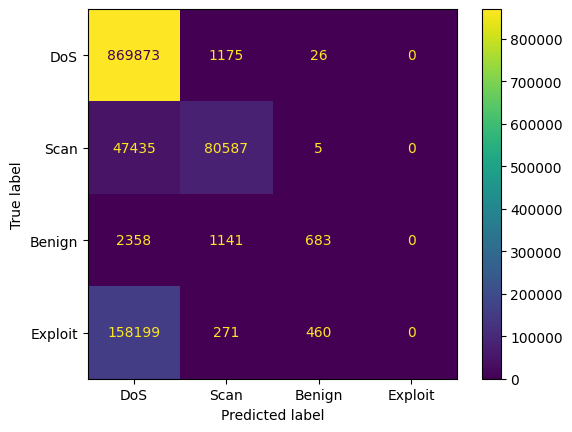

Accuracy:  0.9988359954711569
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    909496
         DoS       1.00      1.00      1.00    152245
     Exploit       0.98      0.97      0.98      7120
        Scan       0.99      1.00      0.99     63437

    accuracy                           1.00   1132298
   macro avg       0.99      0.99      0.99   1132298
weighted avg       1.00      1.00      1.00   1132298


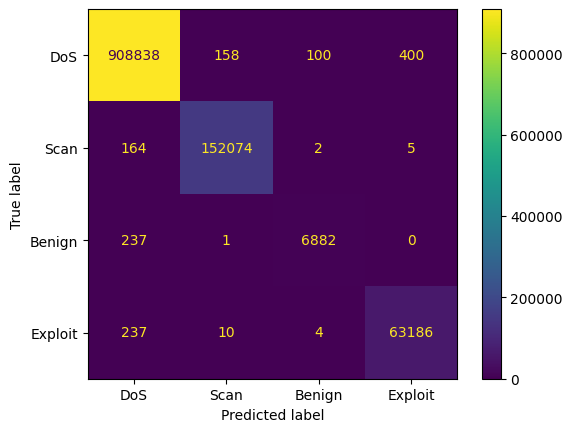

Accuracy:  0.818599516611843
              precision    recall  f1-score   support

      Benign       0.81      1.00      0.89    871074
         DoS       0.99      0.63      0.77    128027
     Exploit       1.00      0.00      0.00      4182
        Scan       0.00      0.00      0.00    158930

    accuracy                           0.82   1162213
   macro avg       0.70      0.41      0.42   1162213
weighted avg       0.72      0.82      0.75   1162213


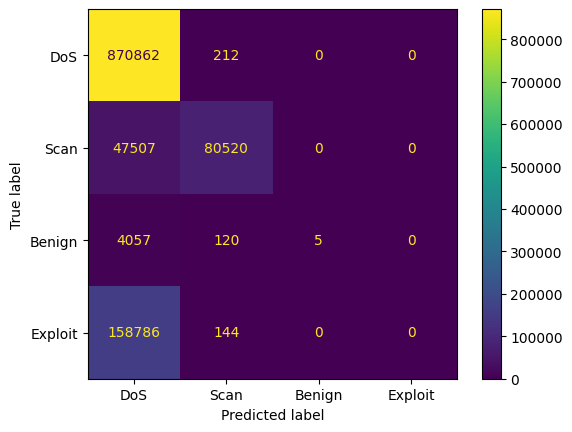

In [13]:
path = "./MachineLearningCVE"

logging.warning('Preprocessing data with splitmode=0.6')
X_train_sm, y_train_sm, X_test_sm, y_test_sm = preprocessing(path, splitmode=0.6)
logging.warning('Preprocessing data with splitmode=None')
X_train_none, y_train_none, X_test_none, y_test_none = preprocessing(path, splitmode=None)

logging.warning('Training decision tree classifier with splitmode=0.6')
clf_dt_sm = train_decision_tree_classifier(X_train_sm, y_train_sm, X_test_sm, y_test_sm, splitmode=0.6)
plot_decision_tree(clf_dt_sm, X_train_sm)
logging.warning('Training decision tree classifier with splitmode=None')
clf_dt_none = train_decision_tree_classifier(X_train_none, y_train_none, X_test_none, y_test_none, splitmode=None)
plot_decision_tree(clf_dt_none, X_train_none)

logging.warning('Training random forest classifier with splitmode=0.6')
train_random_forest_classifier(X_train_sm, y_train_sm, X_test_sm, y_test_sm, splitmode=0.6)
logging.warning('Training random forest classifier with splitmode=None')
train_random_forest_classifier(X_train_none, y_train_none, X_test_none, y_test_none, splitmode=None)